In [1]:
# Preamble (system)
import sys
import os

if sys.version_info[0] < 3:
  raise AssertionError('Please run this notebook with Python 3.')

# Preamble (tools)
import numpy as np
import collections
import contextlib
import functools
import itertools
import more_itertools

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Preamble (ML)
np.random.seed(2027)  # set random seed

#import tensorflow as tf
#tf.random.set_seed(2027)  # set random seed

#import dask
#import dask.array as da

In [2]:
# Preamble (EMTF)
from emtf_nbtools import (get_logger, get_colormap, hist2d_on_binned_data,
                          hist_on_binned_data, emtf_nbtools)

from emtf_algos import *

try:
  import emtf_nnet
except ImportError:
  raise ImportError('Could not import emtf_nnet. It can be found at '
                    'https://github.com/jiafulow/emtf-nnet')

# Get plot style and color map
plt.style.use('tdrstyle.mplstyle')
cm = get_colormap()

# Get logger
logger = get_logger()
logger.info('Using cmssw      : {}'.format(os.environ.get('CMSSW_VERSION', 'N/A')))
logger.info('Using python     : {}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {}'.format(np.__version__))
logger.info('Using matplotlib : {}'.format(matplotlib.__version__))
#logger.info('Using tensorflow : {}'.format(tf.__version__))
#logger.info('Using keras      : {}'.format(tf.keras.__version__))
#logger.info('.. list devices  : {}'.format(tf.config.list_physical_devices()))
#logger.info('Using dask       : {}'.format(dask.__version__))
logger.info('Using emtf-nnet  : {}'.format(emtf_nnet.__version__))

[INFO    ] Using cmssw      : N/A
[INFO    ] Using python     : 3.9.12 (main, Jun  1 2022, 11:38:51) [GCC 7.5.0]
[INFO    ] Using numpy      : 1.20.3
[INFO    ] Using matplotlib : 3.5.1
[INFO    ] Using emtf-nnet  : 0.0.3-dev


In [3]:
# Settings

# zone: (0,1,2) -> eta=(1.98..2.5, 1.55..1.98, 1.2..1.55)
#zone = 0
zone = 1
#zone = 2

# timezone: (0,1,2) -> BX=(0,-1,-2)
timezone = 0

maxevents = 200_000
#maxevents = -1

# Input files
signal_fname = 'signal.210922.npz'
signal_dxy_fname = 'signal_dxy.210922.npz'
bkgnd_fname = 'bkgnd.210922.npz'

logger.info('Using settings   : |')
logger.info('.. zone          : {}'.format(zone))
logger.info('.. timezone      : {}'.format(timezone))
logger.info('.. maxevents     : {}'.format(maxevents))

[INFO    ] Using settings   : |
[INFO    ] .. zone          : 1
[INFO    ] .. timezone      : 0
[INFO    ] .. maxevents     : 200000


### Load data

In [4]:
def load_signal(fname):
  logger.info('Loading from {}'.format(fname))
  with np.load(fname) as loaded:
    out_part = loaded['out_part']
    out_hits_values = loaded['out_hits_values']
    out_hits_row_splits = loaded['out_hits_row_splits']
    out_hits_shape = (out_hits_row_splits.shape[0] - 1,) + (None,) + out_hits_values.shape[1:]
    out_simhits_values = loaded['out_simhits_values']
    out_simhits_row_splits = loaded['out_simhits_row_splits']
    out_simhits_shape = (out_simhits_row_splits.shape[0] - 1,) + (None,) + out_simhits_values.shape[1:]
  logger.info('out_part: {}, out_hits: {}, out_simhits: {}'.format(
      (out_part.shape, out_part.dtype.name),
      (out_hits_shape, out_hits_values.dtype.name),
      (out_simhits_shape, out_simhits_values.dtype.name)))
  return (out_part, (out_hits_values, out_hits_row_splits), (out_simhits_values, out_simhits_row_splits))


def load_bkgnd(fname):
  logger.info('Loading from {}'.format(fname))
  with np.load(fname) as loaded:
    bkg_aux = loaded['out_aux']
    bkg_hits_values = loaded['out_hits_values']
    bkg_hits_row_splits = loaded['out_hits_row_splits']
    bkg_hits_shape = (bkg_hits_row_splits.shape[0] - 1,) + (None,) + bkg_hits_values.shape[1:]
  logger.info('bkg_aux: {} bkg_hits: {}'.format(
      (bkg_aux.shape, bkg_aux.dtype.name),
      (bkg_hits_shape, bkg_hits_values.dtype.name)))
  return (bkg_aux, (bkg_hits_values, bkg_hits_row_splits))

In [5]:
# Load data
out_part, out_hits, out_simhits = load_signal(signal_dxy_fname)

bkg_aux, bkg_hits = load_bkgnd(bkgnd_fname)

out_hits = emtf_nnet.ragged.RaggedTensorValue(out_hits[0], out_hits[1])
out_simhits = emtf_nnet.ragged.RaggedTensorValue(out_simhits[0], out_simhits[1])
bkg_hits = emtf_nnet.ragged.RaggedTensorValue(bkg_hits[0], bkg_hits[1])

[INFO    ] Loading from signal_dxy.210922.npz
[INFO    ] out_part: ((3590546, 10), 'float32'), out_hits: ((3590546, None, 17), 'int32'), out_simhits: ((3590546, None, 17), 'int32')
[INFO    ] Loading from bkgnd.210922.npz
[INFO    ] bkg_aux: ((986400, 2), 'int32') bkg_hits: ((986400, None, 17), 'int32')


### More settings

In [6]:
# particle info
_part_fields = [
  'part_invpt',
  'part_eta',
  'part_phi',
  'part_vx',
  'part_vy',
  'part_vz',
  'part_d0',
  'part_bx',
  'part_sector',
  'part_zone',
]
PartFields = collections.namedtuple('PartFields', _part_fields)
part_fields = PartFields(*range(len(_part_fields)))

# sector_hits info
_sector_hits_fields = [
  'emtf_chamber',
  'emtf_segment',
  'emtf_phi',
  'emtf_bend',
  'emtf_theta1',
  'emtf_theta2',
  'emtf_qual1',
  'emtf_qual2',
  'emtf_time',
  'zones',
  'timezones',
  'cscfr',
  'gemdl',
  'bx',
  'emtf_site',
  'emtf_host',
  'valid',
]
SectorHitsFields = collections.namedtuple('SectorHitsFields', _sector_hits_fields)
sector_hits_fields = SectorHitsFields(*range(len(_sector_hits_fields)))

In [7]:
# Info regarding phi unit
# 80 deg is converted to (80.*60)/16 = 300 units.
# 30 deg is converted to (30.*60)/16 = 112.5 units.
# 300 units aligned to 16-bit is np.floor(300./16)*16 = 288 units.
# 112.5 units aligned to 16-bit is np.floor(112.5/16) * 16 = 112 units,
# 112 is then lowered to the closest odd number 111.

# Image format
num_channels = 1
num_cols = 288  # 80 degrees
num_rows = 8
image_format = (num_rows, num_cols, num_channels)
image_stride = (min_emtf_strip, max_emtf_strip, coarse_emtf_strip)
assert ((max_emtf_strip - min_emtf_strip) // coarse_emtf_strip) == num_cols

# Box image format
num_box_rows = num_rows
num_box_cols = 111  # 30 degrees
num_box_channels = num_channels
box_image_format = (num_box_rows, num_box_cols, num_box_channels)
box_col_offset = (num_box_cols - 1) // 2  # (111-1)/2 = 55
box_col_padding = 54  # ad-hoc, reduces pattern winsz to ~30 deg
assert (num_box_cols % 2) == 1

# Zone-dependent settings
if zone == 0:
  invpt_bins = np.array([-0.49486, -0.30914, -0.18457, -0.06144, 0.06144, 0.18457, 0.30914, 0.49486])
  dzero_bins = np.array([-149.05426, -81.99509, -27.70436, -3.31677, 3.31677, 27.70436, 81.99509, 149.05426])
  invpt_thres = 0.5
  eta_thres = 2.45
  anchor_row = 4  # ME2/1
  activation = 0.06
elif zone == 1:
  invpt_bins = np.array([-0.49430, -0.32499, -0.20098, -0.06069, 0.06069, 0.20098, 0.32499, 0.49430])
  dzero_bins = np.array([-148.39244, -75.48091, -24.77920, -2.74001, 2.74001, 24.77920, 75.48091, 148.39244])
  invpt_thres = 0.45
  eta_thres = 2.05
  anchor_row = 4  # ME2/1
  activation = 0.06
elif zone == 2:
  invpt_bins = np.array([-0.46452, -0.25713, -0.15333, -0.06148, 0.06148, 0.15333, 0.25713, 0.46452])
  dzero_bins = np.array([-148.38953, -73.95163, -24.58335, -3.20768, 3.20768, 24.58335, 73.95163, 148.38953])
  invpt_thres = 0.45
  eta_thres = 1.65
  anchor_row = 3  # ME2/2
  activation = 0.05
else:
  raise RuntimeError('Could not recognize zone: {}'.format(zone))

num_invpt_bins = len(invpt_bins) - 1
num_dzero_bins = len(dzero_bins) - 1


def digitize_d0_and_invpt(d0, invpt):
  # returns (dzero_bin, invpt_bin)
  idx0 = emtf_nbtools.hist_digitize_inclusive(d0, dzero_bins)
  idx1 = emtf_nbtools.hist_digitize_inclusive(invpt, invpt_bins)
  return (idx0, idx1)

### Zone selection

In [8]:
# Make and apply zone_mask

part_zone = out_part[:, part_fields.part_zone].astype(np.int32)
zone_mask = (part_zone == zone)


pt_and_eta_mask = ((np.abs(out_part[:, part_fields.part_invpt]) <= invpt_thres) &
                   (np.abs(out_part[:, part_fields.part_eta]) <= eta_thres))
zone_mask &= pt_and_eta_mask

atleast_1hit_mask = (out_simhits.row_lengths != 0)
zone_mask &= atleast_1hit_mask

zone_part = out_part[zone_mask]
zone_hits = emtf_nnet.ragged.ragged_row_boolean_mask(out_hits, zone_mask)
zone_simhits = emtf_nnet.ragged.ragged_row_boolean_mask(out_simhits, zone_mask)

logger.info('zone_part: {} zone_hits: {} zone_simhits: {}'.format(
    zone_part.shape, zone_hits.shape, zone_simhits.shape))

[INFO    ] zone_part: (623314, 10) zone_hits: (623314, None, 17) zone_simhits: (623314, None, 17)


In [9]:
# Debug
with np.printoptions(linewidth=100, threshold=1000):
  for ievt in range(5):
    print('Event {}'.format(ievt))
    print(zone_part[ievt])
    print(zone_hits[ievt])
    print(zone_simhits[ievt])

Event 0
[  0.15613873  -1.76242     -2.118857    13.199623   -21.865194     1.8294494  -22.529665
   0.           9.           1.        ]
[[  10    0 3722    0   40    0    6   10    0    2    4    0    0    0    0    0    1]
 [  19    0 3536    0   40    0    6   10    0    2    4    1    0    0    2    3    1]
 [  42    0 3497    0   39    0    6   10    0    2    4    0    0    0    4    8    1]
 [  64    0 3774    0   42    0    0    0    0    2    4    0    1    0    9    9    1]
 [  73    0 3548    0   40    0    0    0    0    2    4    1    1    0   10   12    1]
 [  87    0 3495    0   41    0    0    0    0    2    4    0    1    0    7   15    1]]
[[  10    0 3721    0   41    0    0    0    0    2    4    0    0    0    0    0    1]
 [  19    0 3538    0   41    0    0    0    0    2    4    0    0    0    2    3    1]
 [  42    0 3497    0   40    0    0    0    0    2    4    0    0    0    4    8    1]
 [  64    0 3773    0   42    0    0    0    0    2    4    0    0  

### Build images

In [10]:
# Build images

def build_zone_images():
  # zone_images_gt are made from sim hits, while zone_images are made from trigger primitives.
  # 'gt' stands for ground truth.
  zone_images_gt = np.zeros((zone_part.shape[0],) + image_format, dtype=bool)
  zone_images = np.zeros((zone_part.shape[0],) + image_format, dtype=bool)

  # Get hit variables
  zone_simhits_row_splits = zone_simhits.row_splits
  zone_simhits_emtf_phi = zone_simhits.values[:, sector_hits_fields.emtf_phi]
  zone_simhits_emtf_host = zone_simhits.values[:, sector_hits_fields.emtf_host]
  zone_simhits_zones = zone_simhits.values[:, sector_hits_fields.zones]
  zone_simhits_timezones = zone_simhits.values[:, sector_hits_fields.timezones]
  zone_simhits_valid = zone_simhits.values[:, sector_hits_fields.valid].astype(bool)

  zone_hits_row_splits = zone_hits.row_splits
  zone_hits_emtf_phi = zone_hits.values[:, sector_hits_fields.emtf_phi]
  zone_hits_emtf_host = zone_hits.values[:, sector_hits_fields.emtf_host]
  zone_hits_zones = zone_hits.values[:, sector_hits_fields.zones]
  zone_hits_timezones = zone_hits.values[:, sector_hits_fields.timezones]
  zone_hits_valid = zone_hits.values[:, sector_hits_fields.valid].astype(bool)

  # Perform (vectorized) calculations
  zone_simhits_valid = ((zone_simhits_zones & (1 << ((num_emtf_zones - 1) - zone))).astype(bool) &
                        (zone_simhits_timezones & (1 << ((num_emtf_timezones - 1) - timezone))).astype(bool) &
                        zone_simhits_valid)
  zone_simhits_img_row = find_emtf_img_row(zone_simhits_emtf_host, zone=zone)
  zone_simhits_img_col = find_emtf_img_col(zone_simhits_emtf_phi)

  zone_hits_valid = ((zone_hits_zones & (1 << ((num_emtf_zones - 1) - zone))).astype(bool) &
                     (zone_hits_timezones & (1 << ((num_emtf_timezones - 1) - timezone))).astype(bool) &
                     zone_hits_valid)
  zone_hits_img_row = find_emtf_img_row(zone_hits_emtf_host, zone=zone)
  zone_hits_img_col = find_emtf_img_col(zone_hits_emtf_phi)

  # Build zone_images_gt
  _build_zone_images(zone_simhits_row_splits,
                     zone_simhits_valid,
                     zone_simhits_img_row,
                     zone_simhits_img_col,
                     zone_images_gt)
  # Build zone_images
  _build_zone_images(zone_hits_row_splits,
                     zone_hits_valid,
                     zone_hits_img_row,
                     zone_hits_img_col,
                     zone_images)
  return (zone_images_gt, zone_images)


def _build_zone_images(zone_simhits_row_splits,
                       zone_simhits_valid,
                       zone_simhits_img_row,
                       zone_simhits_img_col,
                       zone_images_gt):
  # If valid, set bit at (row, col, channel) to 1
  def func(ievt, valid, row, col):
    if valid and (row >= 0) and (col >= 0):
      zone_images_gt[ievt, row, col, 0] = 1

  zone_simhits_row_indices = emtf_nnet.ragged.ragged_row_splits_to_segment_ids(zone_simhits_row_splits)
  iterables = zip(zone_simhits_row_indices, zone_simhits_valid, zone_simhits_img_row, zone_simhits_img_col)
  more_itertools.consume(itertools.starmap(func, iterables))

In [11]:
# Display images

def display_zone_image(img, cmap=cm.blue_hot, figsize=(10,2)):
  fig, ax = plt.subplots(figsize=figsize)
  ax.imshow(img[..., 0], origin='lower', interpolation='none', aspect='auto', cmap=cmap,
            vmin=0, vmax=1.6)
  ax.set_yticks(range(len(img_row_labels[zone])))
  ax.set_yticklabels(img_row_labels[zone], fontsize=7)
  ax.grid(False)
  plt.show()

In [12]:
%%time

zone_images_gt, zone_images = build_zone_images()

logger.info('zone_images_gt: {} zone_images: {}'.format(zone_images_gt.shape, zone_images.shape))

[INFO    ] zone_images_gt: (623314, 8, 288, 1) zone_images: (623314, 8, 288, 1)


CPU times: user 24.2 s, sys: 1.42 s, total: 25.6 s
Wall time: 25.6 s


In [13]:
# Remake zone_mask

# Reduce on axis=(-2,-1), then count num of stations on axis=-3 (row)
#atleast_2stns_mask = (zone_images_gt.any(axis=-1).any(axis=-1).sum(axis=-1) >= 2)
atleast_2stns_mask = zone_images_gt.any(axis=-1).any(axis=-1)
if zone == 0:
  atleast_2stns_mask = np.stack([
      atleast_2stns_mask[..., [0,]].any(axis=-1),
      atleast_2stns_mask[..., [1,2,]].any(axis=-1),
      atleast_2stns_mask[..., [3,4,]].any(axis=-1),
      atleast_2stns_mask[..., [5,6,]].any(axis=-1),
      atleast_2stns_mask[..., [7,]].any(axis=-1),
  ], axis=-1).sum(axis=-1) >= 2
elif zone == 1:
  atleast_2stns_mask = np.stack([
      atleast_2stns_mask[..., [0,1,]].any(axis=-1),
      atleast_2stns_mask[..., [2,]].any(axis=-1),
      atleast_2stns_mask[..., [3,4,]].any(axis=-1),
      atleast_2stns_mask[..., [5,6,]].any(axis=-1),
      atleast_2stns_mask[..., [7,]].any(axis=-1),
  ], axis=-1).sum(axis=-1) >= 2
elif zone == 2:
  atleast_2stns_mask = np.stack([
      atleast_2stns_mask[..., [0,1,]].any(axis=-1),
      atleast_2stns_mask[..., [2,3,]].any(axis=-1),
      atleast_2stns_mask[..., [4,5,]].any(axis=-1),
      atleast_2stns_mask[..., [6,7,]].any(axis=-1),
  ], axis=-1).sum(axis=-1) >= 2

zone_mask = atleast_2stns_mask

zone_part = zone_part[zone_mask]
zone_hits = emtf_nnet.ragged.ragged_row_boolean_mask(zone_hits, zone_mask)
zone_simhits = emtf_nnet.ragged.ragged_row_boolean_mask(zone_simhits, zone_mask)

zone_images_gt = zone_images_gt[zone_mask]
zone_images = zone_images[zone_mask]

zone_part_pt_values = np.reciprocal(np.abs(zone_part[:, part_fields.part_invpt]))
zone_part_eta_values = zone_part[:, part_fields.part_eta]

logger.info('zone_images_gt: {} zone_images: {}'.format(zone_images_gt.shape, zone_images.shape))

[INFO    ] zone_images_gt: (618818, 8, 288, 1) zone_images: (618818, 8, 288, 1)


Event 0
pt: 6.405 eta: -1.762


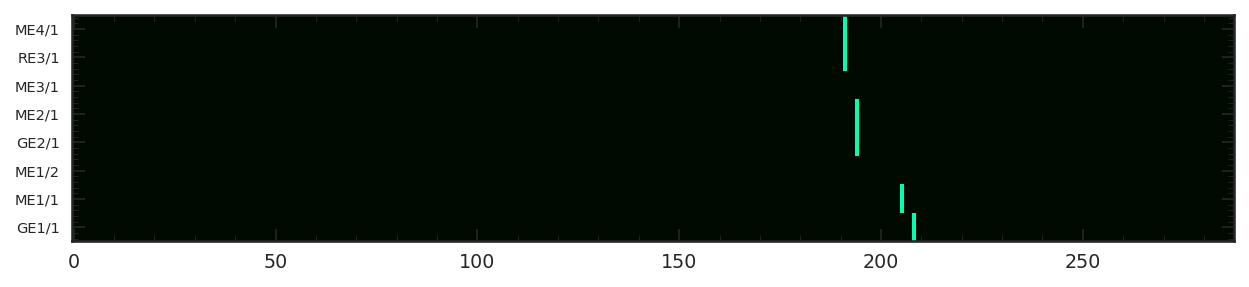

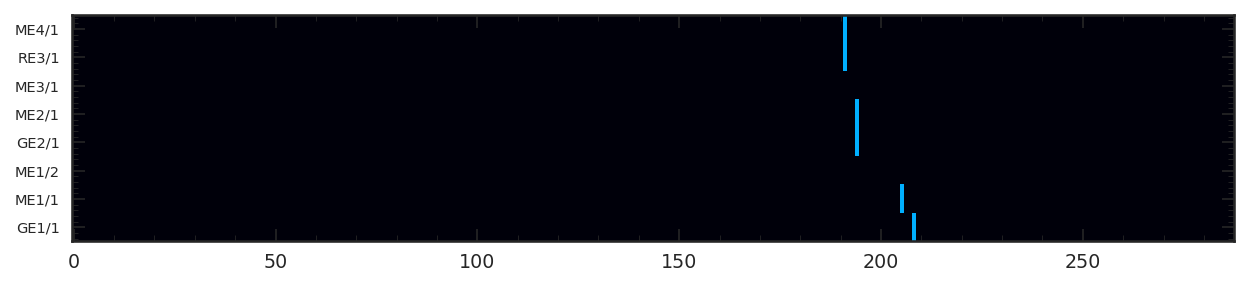

Event 1
pt: 2.801 eta: -1.499


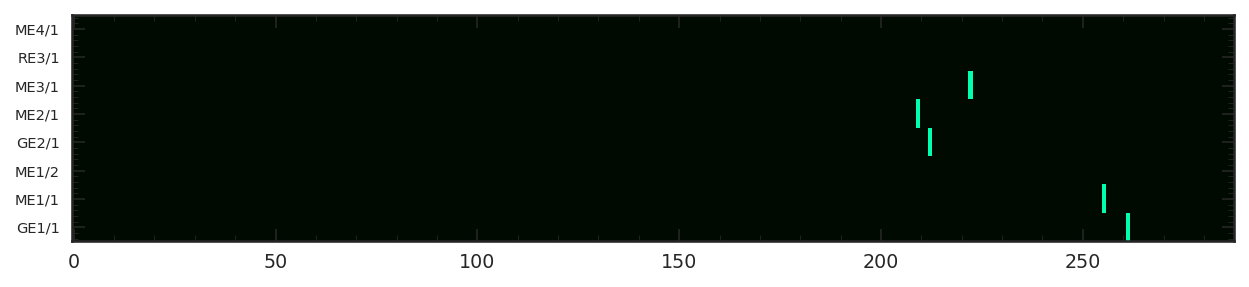

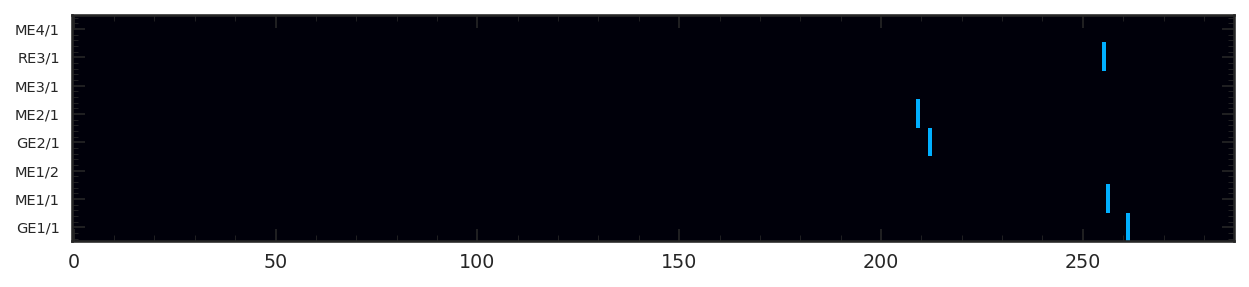

Event 2
pt: 3.362 eta: -1.708


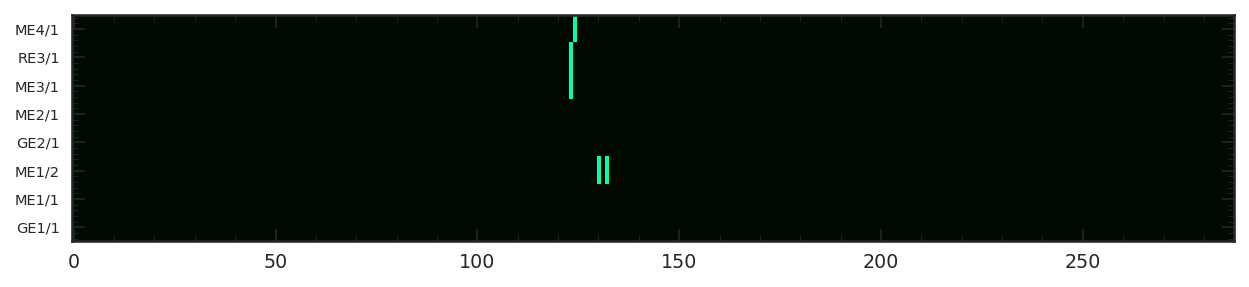

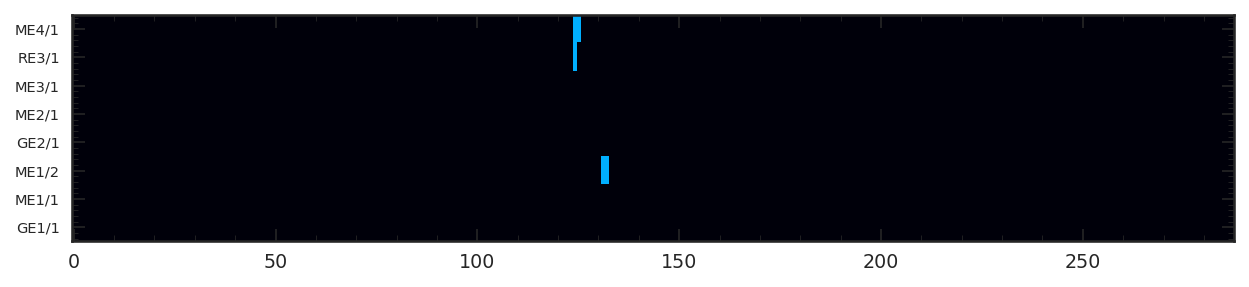

Event 3
pt: 13.021 eta: -1.449


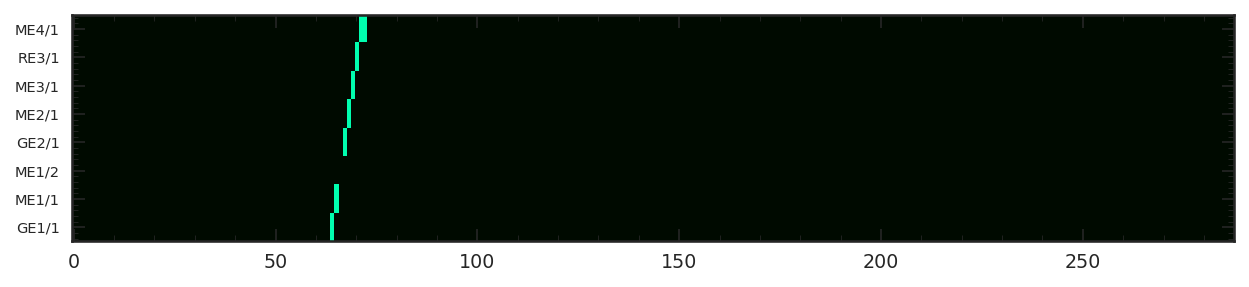

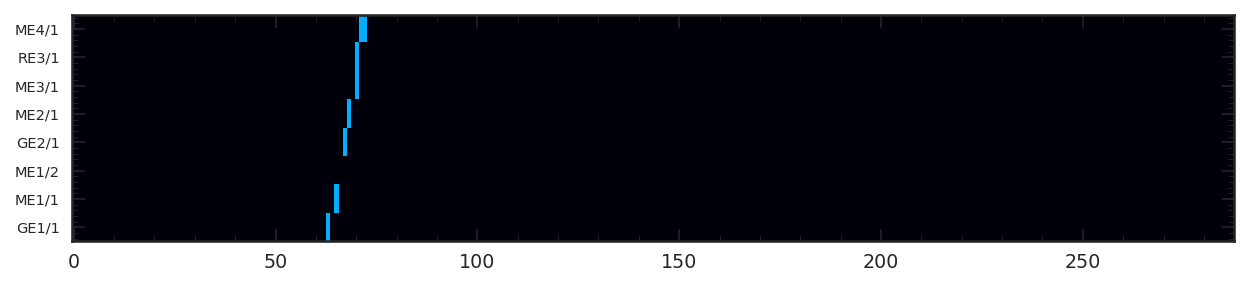

Event 4
pt: 7.116 eta: -1.384


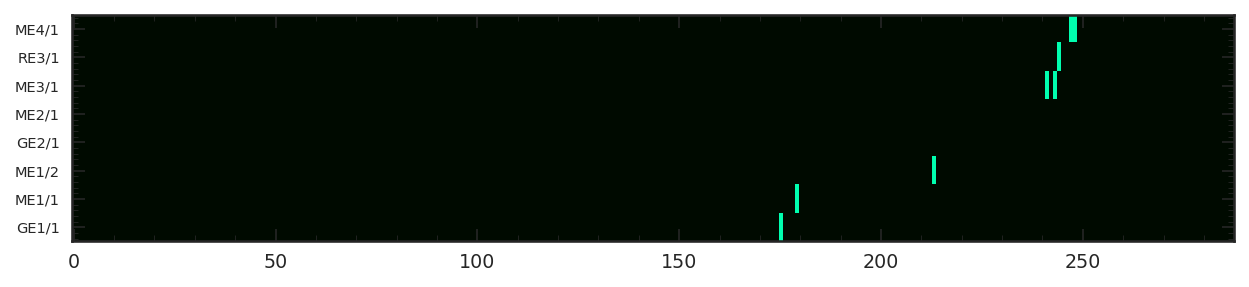

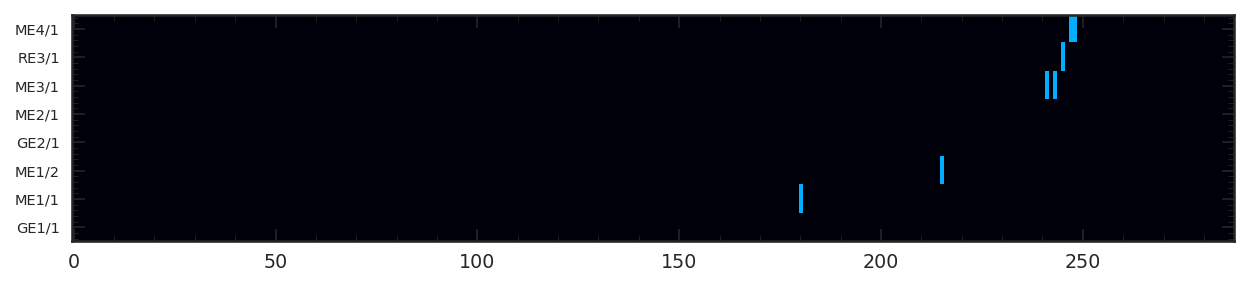

In [14]:
# Debug
for ievt in range(5):
  print('Event {}'.format(ievt))
  print('pt: {:.3f} eta: {:.3f}'.format(zone_part_pt_values[ievt], zone_part_eta_values[ievt]))
  display_zone_image(zone_images_gt[ievt], cmap=cm.green_hot)
  display_zone_image(zone_images[ievt])

In [15]:
# Build boxes

def get_box_ranges(anchors):
  start = np.maximum(0, anchors - box_col_offset)
  stop = np.minimum(num_cols, anchors + box_col_offset + 1)
  b_start = np.maximum(0, num_box_cols - stop)
  b_stop = np.minimum(num_box_cols, num_cols - start)
  return (start, stop, b_start, b_stop)


def build_boxes():
  # 5 indices: (dzero_bin, invpt_bin, img_row, img_col, img_channel)
  boxes = np.zeros((num_dzero_bins, num_invpt_bins) + box_image_format, dtype=np.float32)

  box_bins = digitize_d0_and_invpt(zone_part[:, part_fields.part_d0],
                                   zone_part[:, part_fields.part_invpt])
  box_bins_mir = ((num_dzero_bins - 1) - box_bins[0],
                  (num_invpt_bins - 1) - box_bins[1])

  # Canon images
  _build_boxes(zone_images_gt,
               box_bins,
               boxes)
  # Mirror images
  _build_boxes(zone_images_gt[:, :, ::-1, :],
               box_bins_mir,
               boxes)
  return (boxes, box_bins)


def _build_boxes(zone_images_gt,
                 box_bins,
                 boxes):
  def normalize(zone_images_gt):
    norm = zone_images_gt.sum(axis=-1).sum(axis=-1)  # reduce on axis=(-2,-1)
    norm[norm == 0] = 1
    zone_images_gt = zone_images_gt.astype(np.float32) / norm[:, :, np.newaxis, np.newaxis]
    return zone_images_gt

  def func(dzero_bin, invpt_bin, img, valid, start, stop, b_start, b_stop):
    # If anchor_row is valid, accumulate 'img' sliced from 'start' to 'stop'
    # into 'box' sliced from 'b_start' to 'b_stop'
    if valid:
      box = boxes[dzero_bin, invpt_bin]
      box[:, b_start:b_stop, 0] += img[:, start:stop, 0]

  anchors_valid = np.any(zone_images_gt[:, anchor_row, :, 0], axis=-1)
  anchors = np.argmax(zone_images_gt[:, anchor_row, :, 0], axis=-1)
  box_ranges = get_box_ranges(anchors)
  zone_images_gt = normalize(zone_images_gt)

  iterables = zip(box_bins[0], box_bins[1], zone_images_gt, anchors_valid,
                  box_ranges[0], box_ranges[1], box_ranges[2], box_ranges[3])
  more_itertools.consume(itertools.starmap(func, iterables))


def postprocess_boxes(boxes, antialias=True):
  tmp_boxes = boxes.copy()
  # Apply anti-aliasing to anchor_row (ME2) and anchor_row-1 (RE2 or GE2)
  if antialias:
    kernel = np.array([1., 2., 1.], dtype=boxes.dtype)
    kernel /= kernel.sum()
    for i in range(tmp_boxes.shape[0]):
      for j in range(tmp_boxes.shape[1]):
        for k in [anchor_row, anchor_row-1]:
          for l in range(1, tmp_boxes.shape[3]-1):
            window = boxes[i, j, k, (l-1):(l+2), 0]
            tmp_boxes[i, j, k, l, 0] = (window * kernel).sum()

  # Normalization
  norm = np.sqrt(np.square(tmp_boxes).sum(axis=-1).sum(axis=-1))
  norm[norm == 0] = 1
  tmp_boxes /= norm[:, :, :, np.newaxis, np.newaxis]
  return (tmp_boxes, boxes)

In [16]:
# Display boxes

def display_boxes(boxes, cmap=None, figsize=(7.5,7.5)):
  fig, axs = plt.subplots(num_dzero_bins, num_invpt_bins, figsize=figsize, sharex=True, sharey=True,
                          gridspec_kw=dict(wspace=0.1, hspace=0.1))
  for i in range(num_dzero_bins):
    for j in range(num_invpt_bins):
      ax = axs[(num_dzero_bins-1)-i, j]  # axs[0,0] is top left
      img = boxes[i, j]
      ax.imshow(img[..., 0], origin='lower', interpolation='none', aspect='auto', cmap=cmap)
      ax.set_xticklabels([])
      ax.set_yticklabels([])
      ax.grid(False)
      for x in [-40, -20, 0, +20, +40]:  # custom grid lines
        ax.axvline(box_col_offset+x, color='w', alpha=0.4, linewidth=0.5, linestyle=':')
  plt.show()

def display_box(img, cmap=None, figsize=(3,3)):
  fig, ax = plt.subplots(figsize=figsize)
  ax.imshow(img[..., 0], origin='lower', interpolation='none', aspect='auto', cmap=cmap)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.grid(False)
  for x in [-40, -20, 0, +20, +40]:  # custom grid lines
    ax.axvline(box_col_offset+x, color='w', alpha=0.4, linewidth=0.5, linestyle=':')
  plt.show()

In [17]:
%%time

boxes, box_bins = build_boxes()
boxes_norm, boxes = postprocess_boxes(boxes)

logger.info('boxes_norm: {} boxes: {}'.format(boxes_norm.shape, boxes.shape))

[INFO    ] boxes_norm: (7, 7, 8, 111, 1) boxes: (7, 7, 8, 111, 1)


CPU times: user 25.2 s, sys: 25.7 s, total: 50.9 s
Wall time: 50.9 s


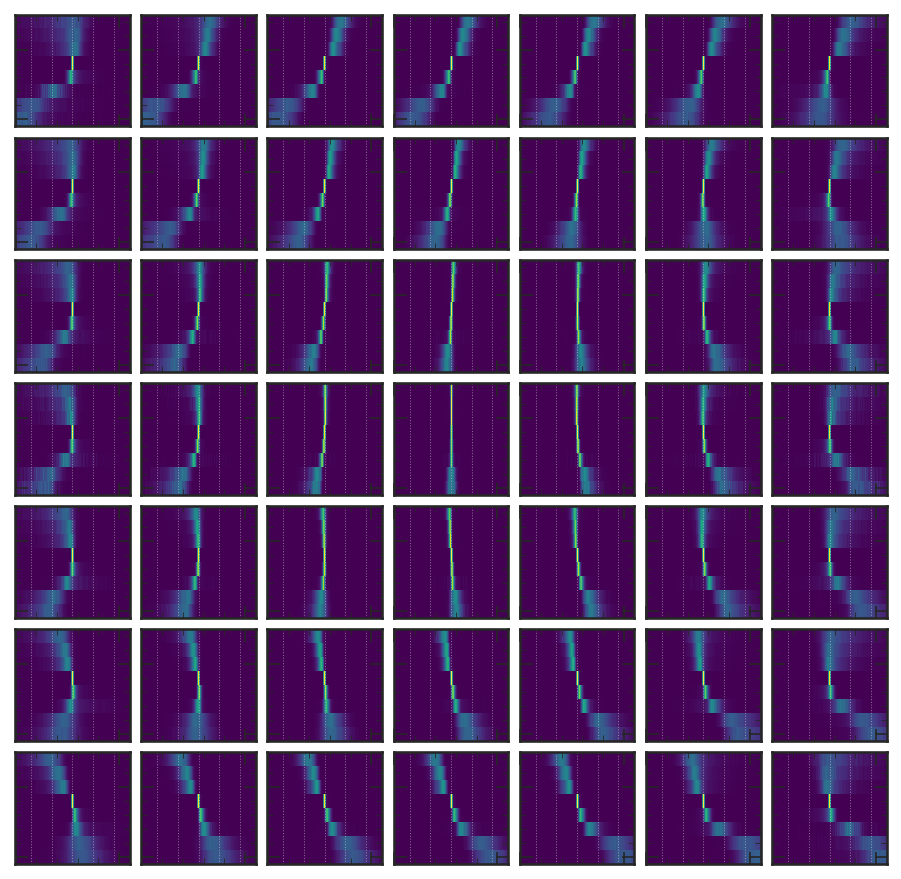

In [18]:
display_boxes(boxes_norm)

In [19]:
# Crop zone images using boxes

def build_crop_images():
  # crop_images_gt are made from sim hits, while crop_images are made from trigger primitives.
  # 'gt' stands for ground truth.
  crop_images_gt = np.zeros((zone_part.shape[0],) + box_image_format, dtype=bool)
  crop_images = np.zeros((zone_part.shape[0],) + box_image_format, dtype=bool)
  zone_images_anchors = np.zeros(zone_part.shape[0], dtype=np.int32)

  # Find zone_images_anchors
  _build_crop_images_0(zone_images_gt,
                       box_bins,
                       boxes_norm,
                       zone_images_anchors)

  # Build crop_images_gt
  _build_crop_images_1(zone_images_gt,
                       zone_images_anchors,
                       crop_images_gt)
  # Build crop_images
  _build_crop_images_1(zone_images,
                       zone_images_anchors,
                       crop_images)
  return (crop_images_gt, crop_images, zone_images_anchors)


def _build_crop_images_0(zone_images_gt,
                         box_bins,
                         boxes_norm,
                         zone_images_anchors):
  def func(ievt, dzero_bin, invpt_bin, img):
    # Pseudo 2D convolution by applying 1D convolution multiple times and summing the results
    # Note the box has to be flipped before 1D convolution
    box = boxes_norm[dzero_bin, invpt_bin]
    convolved = np.add.reduce([
        np.convolve(img[i, :, 0], box[i, ::-1, 0], mode='same')
        for i in range(img.shape[0])])
    # Get the best anchor_col
    zone_images_anchors[ievt] = np.argmax(convolved)

  iterables = zip(itertools.count(), box_bins[0], box_bins[1], zone_images_gt)
  more_itertools.consume(itertools.starmap(func, iterables))


def _build_crop_images_1(zone_images_gt,
                         zone_images_anchors,
                         crop_images_gt):
  def func(ievt, img, start, stop, b_start, b_stop):
    crop_images_gt[ievt, :, b_start:b_stop, 0] = img[:, start:stop, 0]

  box_ranges = get_box_ranges(zone_images_anchors)
  iterables = zip(itertools.count(), zone_images_gt, box_ranges[0], box_ranges[1],
                  box_ranges[2], box_ranges[3])
  more_itertools.consume(itertools.starmap(func, iterables))

In [20]:
%%time

crop_images_gt, crop_images, zone_images_anchors = build_crop_images()

logger.info('crop_images_gt: {} crop_images: {} zone_images_anchors: {}'.format(
    crop_images_gt.shape, crop_images.shape, zone_images_anchors.shape))

[INFO    ] crop_images_gt: (618818, 8, 111, 1) crop_images: (618818, 8, 111, 1) zone_images_anchors: (618818,)


CPU times: user 1min 20s, sys: 455 ms, total: 1min 20s
Wall time: 1min 20s


Event 0
pt: 6.405 eta: -1.762


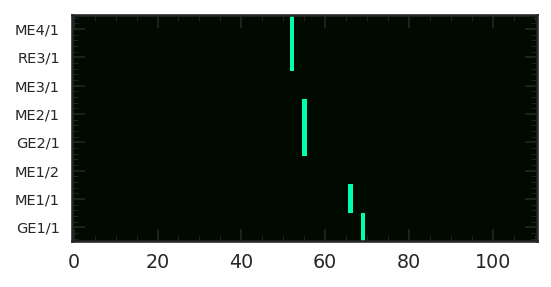

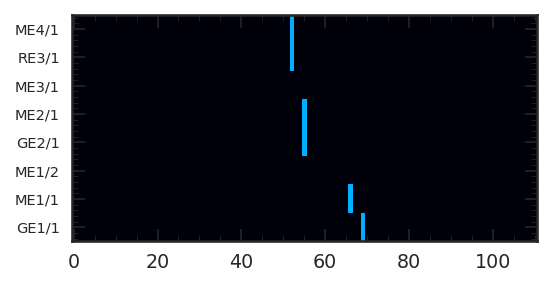

Event 1
pt: 2.801 eta: -1.499


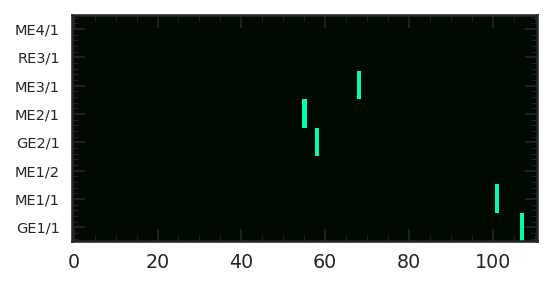

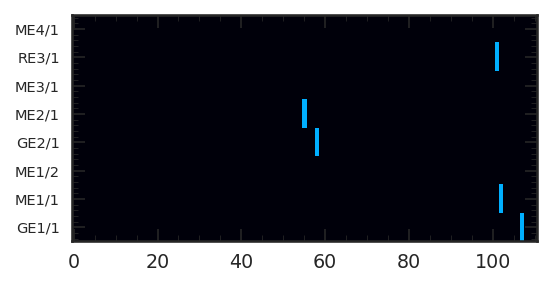

Event 2
pt: 3.362 eta: -1.708


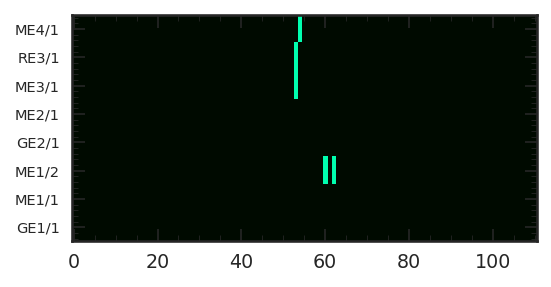

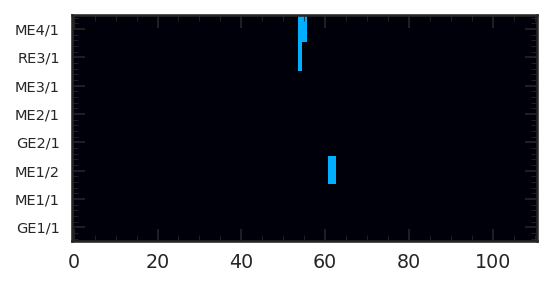

Event 3
pt: 13.021 eta: -1.449


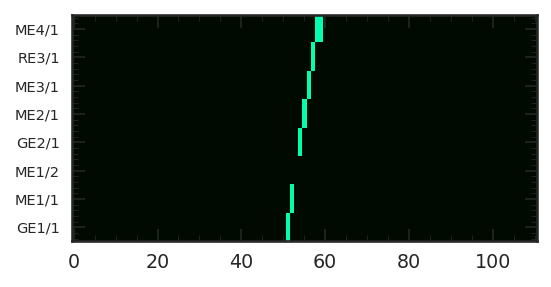

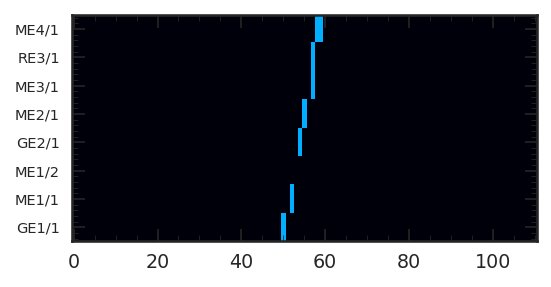

Event 4
pt: 7.116 eta: -1.384


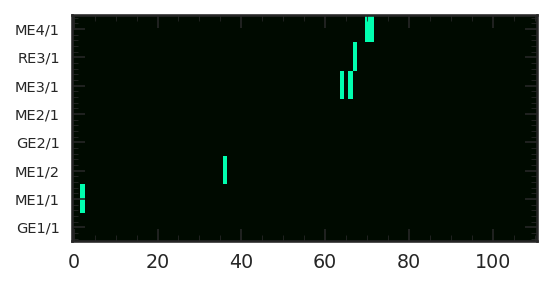

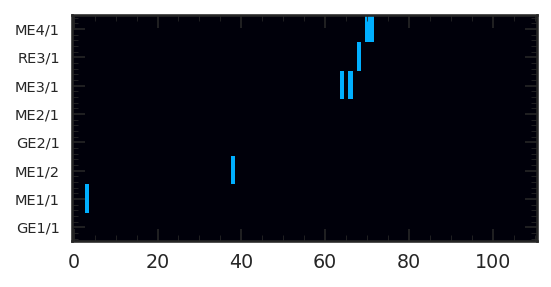

In [21]:
# Debug
for ievt in range(5):
  print('Event {}'.format(ievt))
  print('pt: {:.3f} eta: {:.3f}'.format(zone_part_pt_values[ievt], zone_part_eta_values[ievt]))
  display_zone_image(crop_images_gt[ievt], figsize=(4,2), cmap=cm.green_hot)
  display_zone_image(crop_images[ievt], figsize=(4,2))

In [22]:
# Debug
print(zone_images_anchors[:100])

[194 209 125  68 232 158 209 268 130 170 161 101  62 112 230 223 263  66
 265 138 240 185 172 175 152 118 154 245 198 255 144  35 100 131 159 231
 178  85 247 188 136 133 176 131 237 138  68 125 167 181 139 138  89  97
 258 122  52 187 272  65  55 207  94 179 162 105  87  65  68  62 108  47
 153 262  22 234 117 220 266 162 115 196 211 170  52 222  93  65  85 251
 242 245 141 156 114 139  60 255  33 185]


In [23]:
def build_crop_images_bkg():
  # Refer to build_zone_images() and build_crop_images()
  crop_images_bkg = np.zeros((bkg_aux.shape[0],) + box_image_format, dtype=bool)

  bkg_hits_row_splits = bkg_hits.row_splits
  bkg_hits_emtf_phi = bkg_hits.values[:, sector_hits_fields.emtf_phi]
  bkg_hits_emtf_host = bkg_hits.values[:, sector_hits_fields.emtf_host]
  bkg_hits_zones = bkg_hits.values[:, sector_hits_fields.zones]
  bkg_hits_timezones = bkg_hits.values[:, sector_hits_fields.timezones]
  bkg_hits_valid = bkg_hits.values[:, sector_hits_fields.valid].astype(bool)

  bkg_hits_valid = ((bkg_hits_zones & (1 << ((num_emtf_zones - 1) - zone))).astype(bool) &
                    (bkg_hits_timezones & (1 << ((num_emtf_timezones - 1) - timezone))).astype(bool) &
                    bkg_hits_valid)
  bkg_hits_img_row = find_emtf_img_row(bkg_hits_emtf_host, zone=zone)
  bkg_hits_img_col = find_emtf_img_col(bkg_hits_emtf_phi)

  # Build crop_images_bkg
  _build_crop_images_bkg(bkg_hits_row_splits,
                         bkg_hits_valid,
                         bkg_hits_img_row,
                         bkg_hits_img_col,
                         crop_images_bkg)
  return crop_images_bkg


def _build_crop_images_bkg(bkg_hits_row_splits,
                           bkg_hits_valid,
                           bkg_hits_img_row,
                           bkg_hits_img_col,
                           crop_images_bkg):
  # If valid, set bit at (row, col, channel) to 1
  def func(ievt, valid, row, col):
    # 10 is a fudge number
    anchor = num_cols - num_box_cols - 10
    start = anchor - box_col_offset
    stop = anchor + box_col_offset + 1
    if valid and (row >= 0) and (col >= 0) and (start <= col < stop):
      crop_images_bkg[ievt, row, col - start, 0] = 1

  bkg_hits_row_indices = emtf_nnet.ragged.ragged_row_splits_to_segment_ids(bkg_hits_row_splits)
  iterables = zip(bkg_hits_row_indices, bkg_hits_valid, bkg_hits_img_row, bkg_hits_img_col)
  more_itertools.consume(itertools.starmap(func, iterables))

In [24]:
%%time

crop_images_bkg = build_crop_images_bkg()

logger.info('crop_images_bkg: {}'.format(crop_images_bkg.shape))

[INFO    ] crop_images_bkg: (986400, 8, 111, 1)


CPU times: user 3.36 s, sys: 152 ms, total: 3.51 s
Wall time: 3.51 s


Event 0


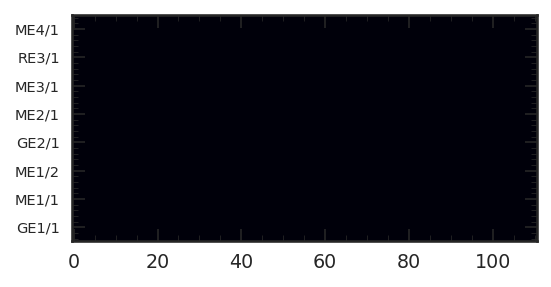

Event 1


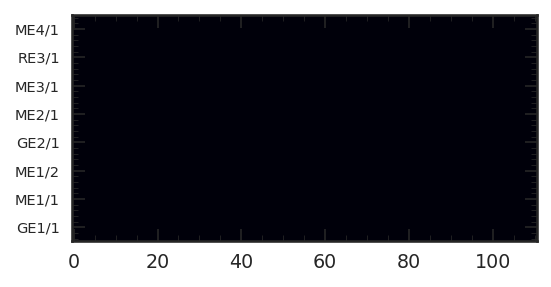

Event 2


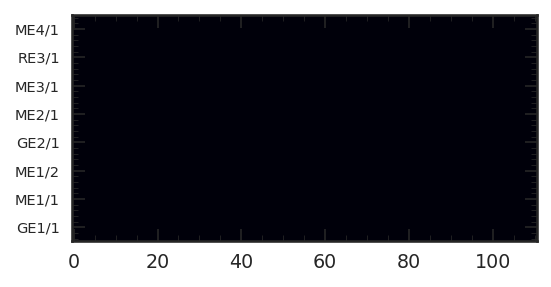

Event 3


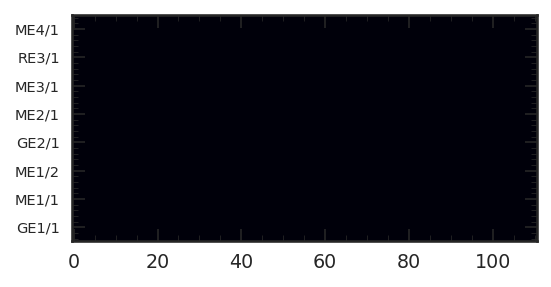

Event 4


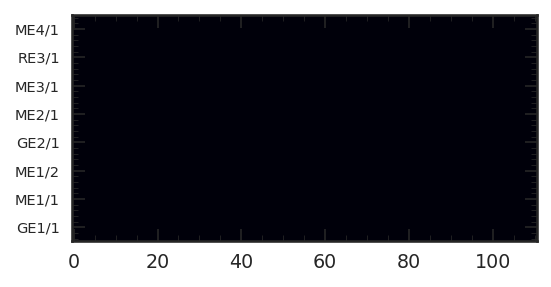

In [25]:
# Debug
for ievt in range(5):
  print('Event {}'.format(ievt))
  display_zone_image(crop_images_bkg[ievt], figsize=(4,2))

In [26]:
# Rebuild boxes from cropped images

def rebuild_boxes():
  # 5 indices: (dzero_bin, invpt_bin, img_row, img_col, img_channel)
  boxes = np.zeros((num_dzero_bins, num_invpt_bins) + box_image_format, dtype=np.float32)

  box_bins = digitize_d0_and_invpt(zone_part[:, part_fields.part_d0],
                                   zone_part[:, part_fields.part_invpt])
  box_bins_mir = ((num_dzero_bins - 1) - box_bins[0],
                  (num_invpt_bins - 1) - box_bins[1])

  # Canon images
  # Use crop_images as input (instead of crop_images_gt)
  _rebuild_boxes(crop_images,
                 box_bins,
                 boxes)
  # Mirror images
  _rebuild_boxes(crop_images[:, :, ::-1, :],
                 box_bins_mir,
                 boxes)
  return (boxes, box_bins)


def _rebuild_boxes(crop_images,
                   box_bins,
                   boxes):
  def func(dzero_bin, invpt_bin, img):
    box = boxes[dzero_bin, invpt_bin]
    box += img

  iterables = zip(box_bins[0], box_bins[1], crop_images)
  more_itertools.consume(itertools.starmap(func, iterables))

In [27]:
%%time

boxes, box_bins = rebuild_boxes()
boxes_norm, boxes = postprocess_boxes(boxes, antialias=False)

logger.info('boxes_norm: {} boxes: {}'.format(boxes_norm.shape, boxes.shape))

[INFO    ] boxes_norm: (7, 7, 8, 111, 1) boxes: (7, 7, 8, 111, 1)


CPU times: user 2.98 s, sys: 68 µs, total: 2.98 s
Wall time: 2.98 s


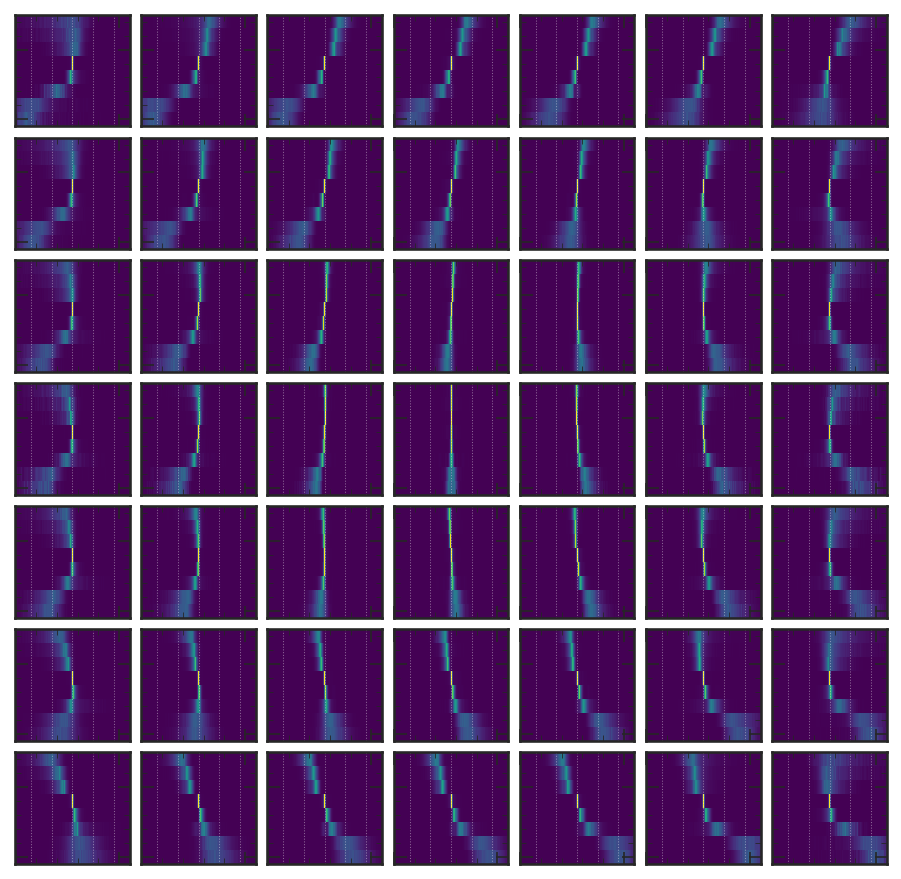

In [28]:
display_boxes(boxes_norm)

In [29]:
def merge_boxes(boxes):
  tmp_boxes = boxes.copy()

  kernel = np.array([1., 6., 15., 20., 15., 6., 1.], dtype=boxes.dtype)
  kernel /= kernel.sum()

  tmp_boxes[:] = 0.
  tmp_boxes[:, (num_invpt_bins // 2)] = (boxes * kernel[:, np.newaxis, np.newaxis, np.newaxis]).sum(axis=1)
  return (tmp_boxes, boxes)

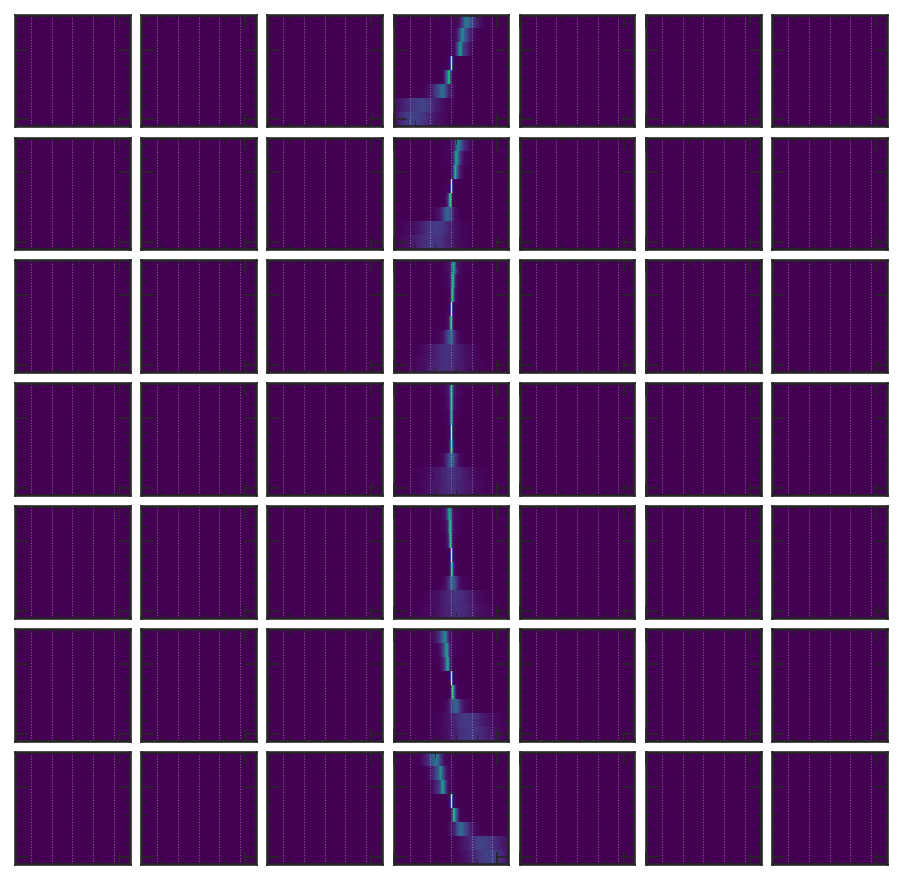

In [30]:
boxes_norm, boxes_norm_old = merge_boxes(boxes_norm)

display_boxes(boxes_norm)

### Create patterns

In [31]:
# Apply activation threshold

boxes_act = (boxes_norm > activation)

# Detect weird spikes
def antispike():
  tmp_boxes = boxes_act.copy()
  for i in range(tmp_boxes.shape[0]):
    for j in range(tmp_boxes.shape[1]):
      for k in range(tmp_boxes.shape[2]):
        img = tmp_boxes[i, j, k, :, 0]
        for l in range(1, img.shape[0]-1):
          if img[l] and not img[l-1] and not img[l+1]:
            print('Found spike at {}'.format((i, j, k, l, 0)))


# Detect wide ranges
def antirange():
  tmp_boxes = boxes_act.copy()
  for i in range(tmp_boxes.shape[0]):
    for j in range(tmp_boxes.shape[1]):
      for k in range(tmp_boxes.shape[2]):
        img = tmp_boxes[i, j, k, :, 0]
        for l in range(1, img.shape[0]-1):
          if img[l] and ((l < (box_col_offset - box_col_padding)) or
                         (l > (box_col_offset + box_col_padding))):
            print('Found wide range at {}'.format((i, j, k, l, 0)))


antispike()
antirange()

Found spike at (3, 3, 0, 38, 0)
Found spike at (3, 3, 0, 72, 0)


In [32]:
# Ad-hoc fixes

if zone == 0:
  boxes_act[3, 3, 1, 43, 0] = 0
  boxes_act[3, 3, 1, 67, 0] = 0
elif zone == 1:
  boxes_act[3, 3, 0, 38, 0] = 0
  boxes_act[3, 3, 0, 72, 0] = 0
elif zone == 2:
  pass

antispike()
antirange()

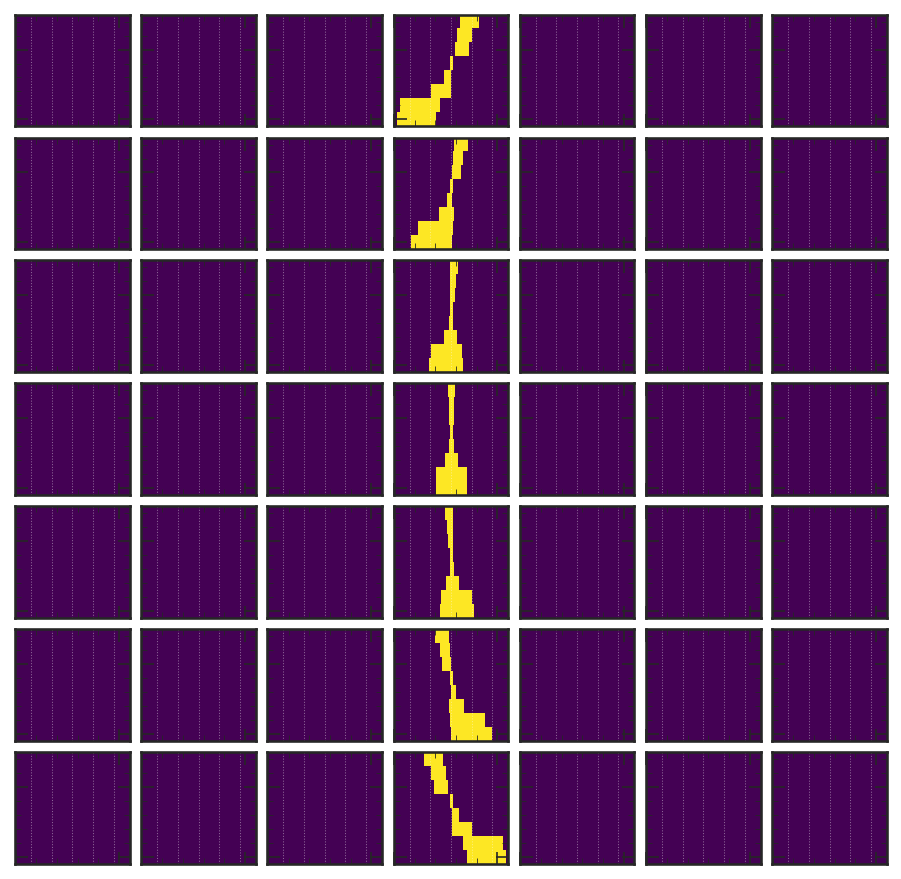

In [33]:
display_boxes(0.8 * boxes_act)

In [34]:
check_pattern_overlaps = False

if check_pattern_overlaps:
  display_box(0.5 * boxes_act[3,3], figsize=(2,2))
  display_box(0.5 * boxes_act[3,3] + 0.5 * boxes_act[4,3], figsize=(2,2))
  display_box(0.5 * boxes_act[4,3] + 0.5 * boxes_act[5,3], figsize=(2,2))
  display_box(0.5 * boxes_act[5,3] + 0.5 * boxes_act[6,3], figsize=(2,2))

In [35]:
check_efficiency_activation = False

if check_efficiency_activation:
  def find_efficiency_activation(tmp_boxes):
    # Count amount of activation before and after applying patterns
    denom = np.zeros((num_dzero_bins, num_invpt_bins), dtype=np.int32)
    numer = np.zeros((num_dzero_bins, num_invpt_bins), dtype=np.int32)

    for i in range(num_dzero_bins):
      for j in range(num_invpt_bins):
        mask = (box_bins[0] == i) & (box_bins[1] == j)
        tmp_images = crop_images[mask]
        tmp_box = tmp_boxes[i, j]
        denom[i, j] = tmp_images.any(axis=-1).any(axis=-1).sum(axis=-1).sum(axis=-1)
        numer[i, j] = (tmp_box & tmp_images).any(axis=-1).any(axis=-1).sum(axis=-1).sum(axis=-1)

    denom[denom == 0] = 1
    result = np.true_divide(numer, denom)
    return result.astype(np.float32)

  with np.printoptions(precision=5):
    for act in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 0.1]:
      tmp_boxes = (boxes_norm > act)
      print(act)
      print(find_efficiency_activation(tmp_boxes))

In [36]:
check_d0_and_invpt_binning = False

if check_d0_and_invpt_binning:
  part_invpt_tmp = zone_part[:, part_fields.part_invpt]
  part_invpt_tmp = np.hstack((part_invpt_tmp, -part_invpt_tmp))
  part_dzero_tmp = zone_part[:, part_fields.part_d0]
  part_dzero_tmp = np.hstack((part_dzero_tmp, -part_dzero_tmp))
  with np.printoptions(precision=5):
    #q = np.percentile(part_invpt_tmp, [0.5,100./7,200./7,300./7,400./7,500./7,600./7,99.5], overwrite_input=True)
    #print('invpt_bins: {}'.format(q))
    #q = np.percentile(part_dzero_tmp, [0.5,300./12,500./12,588./12,612./12,700./12,900./12,99.5], overwrite_input=True)
    #print('dzero_bins: {}'.format(q))
    if zone == 0:
      q = np.percentile(part_invpt_tmp, [0.5, 18.75, 31.25, 43.75, 56.25, 68.75, 81.25, 99.5], overwrite_input=True)
    elif zone == 1:
      q = np.percentile(part_invpt_tmp, [0.5, 17.5, 30.0, 44.0, 56.0, 70.0, 82.5, 99.5], overwrite_input=True)
    elif zone == 2:
      q = np.percentile(part_invpt_tmp, [0.5, 18.75, 31.25, 42.5, 57.5, 68.75, 81.25, 99.5], overwrite_input=True)
    print('invpt_bins: {}'.format(q))

In [37]:
# Debug
for j in range(num_dzero_bins):
  print(1.0 * boxes_act[j, 3, anchor_row, box_col_offset-10:box_col_offset+11].reshape(-1))  # ME2

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [38]:
# Debug
for j in range(num_dzero_bins):
  print(1.0 * boxes_act[j, 3, anchor_row-1, box_col_offset-10:box_col_offset+11].reshape(-1))  # RE2 or GE2

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [39]:
# Create pattern windows

def create_patterns():
  # Find mid from the weighted mean (using boxes)
  patterns_mid = (boxes[..., 0] * (0.5 + np.arange(num_box_cols))).sum(axis=-1)  # reduce on axis=(-2,-1)
  norm = (boxes[..., 0]).sum(axis=-1)
  norm[norm == 0] = 1
  patterns_mid /= norm

  patterns_mid = patterns_mid.astype(np.int32)
  patterns_start = np.zeros(patterns_mid.shape, dtype=np.int32)
  patterns_stop = np.zeros(patterns_mid.shape, dtype=np.int32)
  assert np.all(patterns_mid[3, :, anchor_row] == box_col_offset)
  assert np.all(patterns_mid[3, 3, :] == box_col_offset)

  # Find start, stop (using boxes_act)
  for i in range(boxes_act.shape[0]):
    for j in range(boxes_act.shape[1]):
      for k in range(boxes_act.shape[2]):
        for l in range(boxes_act.shape[3]):
          if boxes_act[i, j, k, l, 0] == 1:
            patterns_start[i, j, k] = l
            break
        for l in reversed(range(boxes_act.shape[3])):
          if boxes_act[i, j, k, l, 0] == 1:
            patterns_stop[i, j, k] = l
            break

  patterns = np.stack([patterns_start, patterns_mid, patterns_stop])
  patterns = np.moveaxis(patterns, 0, -1)
  patterns_winsz = (patterns_stop - patterns_start + 1)
  patterns_winsz[patterns_winsz == 1] = 0
  assert np.all(patterns_winsz < ((box_col_padding * 2) + 1))

  # Sanity check by recreating boxes_act from patterns
  tmp_boxes = np.zeros(boxes_act.shape, dtype=boxes_act.dtype)
  for i in range(patterns.shape[0]):
    for j in range(patterns.shape[1]):
      for k in range(patterns.shape[2]):
        l0, l1, l2 = patterns[i, j, k]
        if l2 > l0:
          tmp_boxes[i, j, k, l0:l2+1, 0] = 1
  assert np.all(tmp_boxes == boxes_act)

  return (patterns, patterns_winsz)


patterns, patterns_winsz = create_patterns()
logger.info('patterns: {} patterns_winsz: {}'.format(patterns.shape, patterns_winsz.shape))

[INFO    ] patterns: (7, 7, 8, 3) patterns_winsz: (7, 7, 8)


In [40]:
# Debug
print(np.array2string(patterns[:, 3], separator=', '))

[[[ 70,  90, 107],
  [ 67,  86, 104],
  [ 56,  65,  74],
  [ 56,  59,  62],
  [ 54,  55,  56],
  [ 39,  45,  51],
  [ 36,  43,  49],
  [ 29,  38,  46]],

 [[ 55,  74,  94],
  [ 54,  71,  87],
  [ 53,  60,  67],
  [ 55,  57,  59],
  [ 54,  55,  56],
  [ 46,  50,  54],
  [ 44,  49,  53],
  [ 40,  47,  52]],

 [[ 44,  60,  76],
  [ 45,  59,  74],
  [ 50,  56,  62],
  [ 54,  56,  57],
  [ 54,  55,  56],
  [ 52,  54,  56],
  [ 51,  54,  56],
  [ 49,  53,  56]],

 [[ 41,  55,  69],
  [ 41,  55,  69],
  [ 49,  55,  61],
  [ 53,  55,  57],
  [ 54,  55,  56],
  [ 53,  55,  57],
  [ 53,  55,  57],
  [ 52,  55,  58]],

 [[ 34,  50,  66],
  [ 36,  51,  65],
  [ 48,  54,  60],
  [ 53,  54,  56],
  [ 54,  55,  56],
  [ 54,  56,  58],
  [ 54,  56,  59],
  [ 54,  57,  61]],

 [[ 16,  36,  55],
  [ 23,  39,  56],
  [ 43,  50,  57],
  [ 51,  53,  55],
  [ 54,  55,  56],
  [ 56,  60,  64],
  [ 57,  61,  66],
  [ 58,  63,  70]],

 [[  3,  20,  40],
  [  6,  24,  43],
  [ 36,  45,  54],
  [ 48,  51,  54],


In [41]:
# Debug
print(np.array2string(patterns_winsz[:, 3], separator=', '))

[[38, 38, 19,  7,  3, 13, 14, 18],
 [40, 34, 15,  5,  3,  9, 10, 13],
 [33, 30, 13,  4,  3,  5,  6,  8],
 [29, 29, 13,  5,  3,  5,  5,  7],
 [33, 30, 13,  4,  3,  5,  6,  8],
 [40, 34, 15,  5,  3,  9, 10, 13],
 [38, 38, 19,  7,  3, 13, 14, 18]]


### Create pattern quality

In [42]:
# Create pattern quality

def create_patterns_quality():
  # Normalize once
  quality_adjust = np.true_divide(patterns_winsz, patterns_winsz[3, 3])
  # l2-sum over axis=-1
  quality_adjust = np.sqrt(np.square(quality_adjust).sum(axis=-1))
  # Fill
  for j in range(num_invpt_bins):
    quality_adjust[:, j] = quality_adjust[:, 3]
  # Normalize again
  quality_adjust_norm = quality_adjust.copy()
  quality_adjust_norm[quality_adjust_norm == 0] = 1
  quality_adjust[quality_adjust != 0] = quality_adjust[3, 3]
  quality_adjust /= quality_adjust_norm
  #print(quality_adjust)

  accumulated = np.zeros((2 ** num_box_rows,), dtype=quality_adjust.dtype)
  accumulated_bkg = np.zeros((2 ** num_box_rows,), dtype=quality_adjust.dtype)
  po2_coeffs = (2 ** np.arange(num_box_rows))  # [1,2,4,8,16,32,64,128]

  # Find hit map
  for i in range(num_dzero_bins):
    for j in range(num_invpt_bins):
      mask = (box_bins[0] == i) & (box_bins[1] == j)
      tmp_images = crop_images[mask]
      if tmp_images.size > 0:
        # Reduce on axis=(-2,-1), then calc dot-product on axis=-3 (row)
        tmp_images = (tmp_images.any(axis=-1).any(axis=-1) * po2_coeffs).sum(axis=-1)
        # np.bincount() is like np.histogram() for unit bin size
        accumulated += (np.bincount(tmp_images) * quality_adjust[i, j])

  # Find hit map (bkg)
  tmp_images = crop_images_bkg
  tmp_images = (tmp_images.any(axis=-1).any(axis=-1) * po2_coeffs).sum(axis=-1)
  accumulated_bkg += np.bincount(tmp_images)
  accumulated_bkg[accumulated_bkg == 0] = 1
  #print(accumulated.min(), accumulated.max(), accumulated.argmin(), accumulated.argmax())
  #print(accumulated_bkg.min(), accumulated_bkg.max(), accumulated_bkg.argmin(), accumulated_bkg.argmax())

  # Calc S/sqrt(B)
  patterns_quality = accumulated.astype(np.float32)
  # Make sure all the bins are nonzero
  patterns_quality[patterns_quality < 1e-5] = patterns_quality[patterns_quality >= 1e-5].min()
  patterns_quality[0] = 0  # set to zero if empty hit
  patterns_quality[po2_coeffs] = 0  # set to zero if single hit
  patterns_quality /= np.sqrt(accumulated_bkg)

  patterns_quality_indices = np.argsort(patterns_quality)
  patterns_quality_ranks = np.zeros(patterns_quality.shape, dtype=np.int32)
  patterns_quality_ranks[patterns_quality_indices] = np.arange(patterns_quality.shape[0])
  return (patterns_quality, patterns_quality_indices, patterns_quality_ranks)


patterns_quality, patterns_quality_indices, patterns_quality_ranks = create_patterns_quality()
logger.info('patterns_quality: {} patterns_quality_indices: {} patterns_quality_ranks: {}'.format(
    patterns_quality.shape, patterns_quality_indices.shape, patterns_quality_ranks.shape))

[INFO    ] patterns_quality: (256,) patterns_quality_indices: (256,) patterns_quality_ranks: (256,)


In [43]:
# Debug
with np.printoptions(threshold=10):
  print(patterns_quality.min(), patterns_quality.max())
  print(patterns_quality)
  print(patterns_quality_indices)
  print(patterns_quality_ranks)
  print()

for i in range(0, 256, 8):
  s = ' '.join(['{:08b}'] * 8)
  print(s.format(*patterns_quality_indices[i:i+8]))

0.0 2318.027
[  0.        0.        0.      ...  86.44541 303.20792 680.6532 ]
[  0   1   2 ... 248 219 251]
[  0   1   2 ... 168 222 243]

00000000 00000001 00000010 10000000 00000100 01000000 00001000 00100000
00010000 10000001 01000001 00100001 00111101 01100001 00101101 10001101
01101101 00110110 00001101 11000001 10001001 01001001 01001101 10000010
10001000 00110101 01000011 00000101 10000011 01000010 00001001 10100001
01101110 00101111 10101101 00101001 01110101 01101001 11001001 00000110
00010101 00100010 10001110 00101110 01010001 10001100 00000011 11001101
01111101 01001110 01100000 10001010 01011101 01110110 00001110 00101000
00101100 10010001 00100011 00100101 11101101 11000010 01010101 00110000
01100010 10001011 00011101 00111110 00010001 00001111 10010110 01100011
11000011 01101111 10000101 10001111 10000110 10101110 00100100 01000101
00110111 01010110 01110001 01001000 01001010 01001111 01011001 00110100
00010110 01100101 01001011 01000110 10101001 00111111 01110111 01100

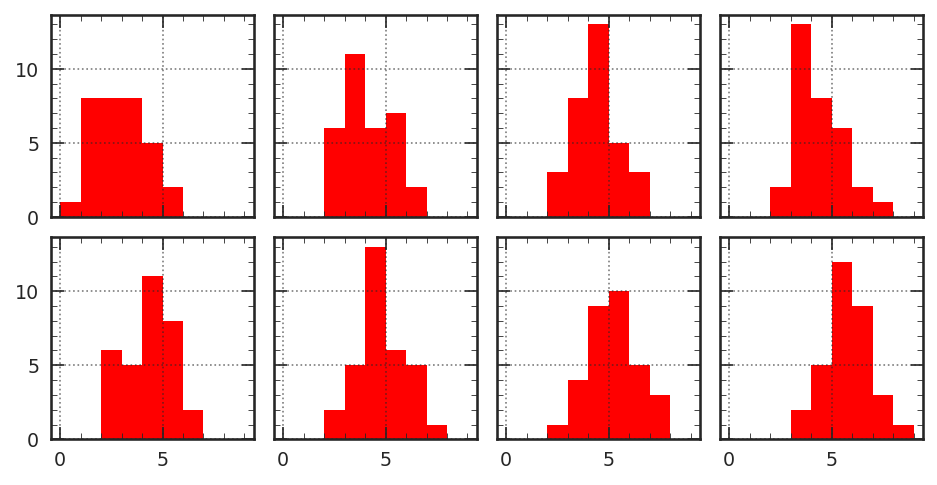

In [44]:
fig, axs = plt.subplots(2, 4, figsize=(7.5, 7.5/2), sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0.1, hspace=0.1))

for i in range(8):
  ax = axs[i//4, i%4]
  hist = np.zeros(num_box_rows + 1, dtype=np.int32)
  edges = np.arange(hist.shape[0] + 1)
  chunks = np.split(patterns_quality_indices, 8)
  for j in chunks[i]:
    kk = 0
    for k in range(num_box_rows):  # count num of set bits
      if j & (1 << k):
        kk += 1
    hist[kk] += 1

  hist_on_binned_data(hist, edges=edges, color='red', ax=ax)

plt.show()

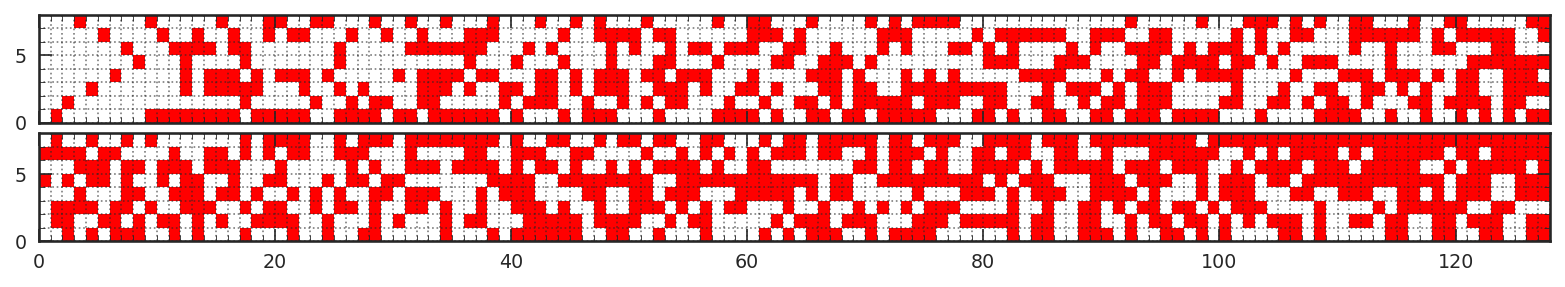

In [45]:
from matplotlib.ticker import AutoMinorLocator

fig, axs = plt.subplots(2, 1, figsize=(13, 2), sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0.1, hspace=0.1))

for i in range(2):
  ax = axs[i]
  hist = np.zeros((patterns_quality_indices.shape[0] // 2, num_box_rows), dtype=np.int32)
  xedges = np.arange(hist.shape[0] + 1)
  yedges = np.arange(hist.shape[1] + 1)
  chunks = np.split(patterns_quality_indices, 2)
  for j in chunks[i]:
    jj = patterns_quality_ranks[j] % (patterns_quality_indices.shape[0] // 2)
    for k in range(num_box_rows):  # check set bits
      if j & (1 << k):
        hist[jj, k] = 1

  hist2d_on_binned_data(hist, xedges=xedges, yedges=yedges, cmap=cm.red_binary, ax=ax)
  ax.grid(True, which='both')
  ax.xaxis.set_minor_locator(AutoMinorLocator(20))
  ax.yaxis.set_minor_locator(AutoMinorLocator(5))

plt.show()

In [46]:
# Write to file
outfile = 'patterns_dxy_zone%i.npz' % zone
outdict = {
  'patterns': patterns,
  'patterns_winsz': patterns_winsz,
  'patt_filters': boxes_act,
  'patt_activations': patterns_quality_ranks,
}
save_np_arrays(outfile, outdict)
logger.info('Wrote to {}'.format(outfile))

[INFO    ] Wrote to patterns_dxy_zone1.npz
